   0  0.1
0  1    0
1  2    0
2  3    0
3  4    0
4  5    0


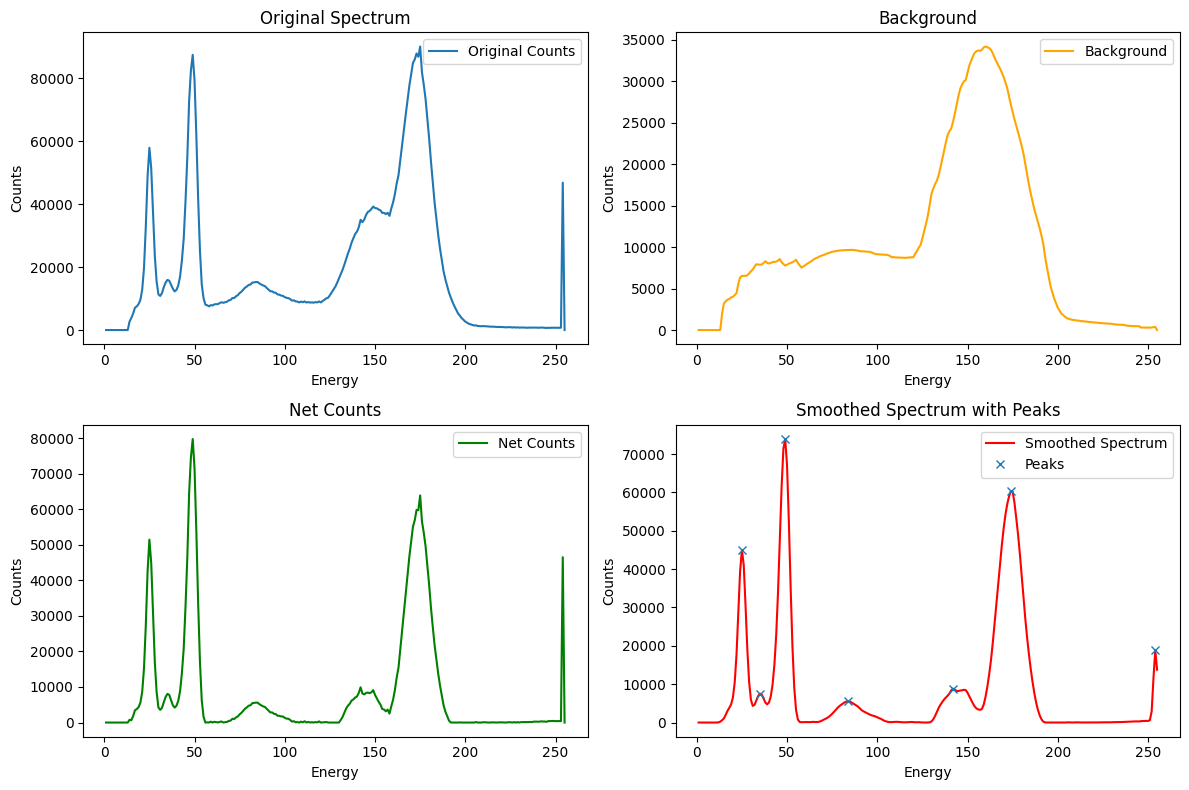

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from scipy.ndimage import gaussian_filter1d

def read_spectrum(file_path):
    # Read the CSV file
    data = pd.read_csv(file_path)
    print(data.head())  # Print the first few rows to check the column names
    energy = data.iloc[:, 0]  # Assuming energy values are in the first column
    counts = data.iloc[:, 1]  # Assuming counts are in the second column
    return energy, counts

def snip_background(counts, width):
    # Implementing SNIP algorithm for background elimination
    background = counts.copy()
    for i in range(width):
        for j in range(i, len(counts) - i):
            background[j] = min(background[j], (background[j - i] + background[j + i]) / 2)
    return background

def identify_peaks(energy, spectrum, height=None, distance=None):
    peaks, properties = find_peaks(spectrum, height=height, distance=distance)
    return peaks, properties

def process_spectrum(file_path, snip_width=10, smoothing_sigma=1.0, peak_height_ratio=0.05, peak_distance=10):
    energy, counts = read_spectrum(file_path)

    # Background elimination
    background = snip_background(counts, snip_width)
    net_counts = counts - background

    # Smoothing the spectrum
    smoothed_counts = gaussian_filter1d(net_counts, sigma=smoothing_sigma)

    # Identify peaks in the smoothed spectrum
    peaks, properties = identify_peaks(energy, smoothed_counts, height=peak_height_ratio*np.max(smoothed_counts), distance=peak_distance)

    return energy, counts, background, net_counts, smoothed_counts, peaks, properties

def plot_spectrum(energy, counts, background, net_counts, smoothed_counts, peaks):
    plt.figure(figsize=(12, 8))

    # Original Counts
    plt.subplot(2, 2, 1)
    plt.plot(energy, counts, label='Original Counts')
    plt.xlabel('Energy')
    plt.ylabel('Counts')
    plt.title('Original Spectrum')
    plt.legend()

    # Background
    plt.subplot(2, 2, 2)
    plt.plot(energy, background, label='Background', color='orange')
    plt.xlabel('Energy')
    plt.ylabel('Counts')
    plt.title('Background')
    plt.legend()

    # Net Counts
    plt.subplot(2, 2, 3)
    plt.plot(energy, net_counts, label='Net Counts', color='green')
    plt.xlabel('Energy')
    plt.ylabel('Counts')
    plt.title('Net Counts')
    plt.legend()

    # Smoothed Spectrum with Peaks
    plt.subplot(2, 2, 4)
    plt.plot(energy, smoothed_counts, label='Smoothed Spectrum', color='red')
    plt.plot(energy[peaks], smoothed_counts[peaks], 'x', label='Peaks')
    plt.xlabel('Energy')
    plt.ylabel('Counts')
    plt.title('Smoothed Spectrum with Peaks')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Example usage
file_path = '15.5.csv'  # Path to your CSV file

# Process the spectrum
energy, counts, background, net_counts, smoothed_counts, peaks, properties = process_spectrum(
    file_path, snip_width=10, smoothing_sigma=1.0, peak_height_ratio=0.05, peak_distance=10)

# Save the results to a new CSV file
result_df = pd.DataFrame({
    'Energy': energy,
    'Original Counts': counts,
    'Background': background,
    'Net Counts': net_counts,
    'Smoothed Spectrum': smoothed_counts,
    'Peak': [1 if i in peaks else 0 for i in range(len(energy))]
})
result_df.to_csv('processed_spectrum.csv', index=False)

# Plot the results
plot_spectrum(energy, counts, background, net_counts, smoothed_counts, peaks)
